# Air Pollution NO₂ Data Analysis

## README

### Overview
This notebook conducts the data processing and comprehensive analysis of nitrogen dioxide (NO₂) pollution using [Sentinel-5P data](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_NO2), with a focus on **Ethiopia (Addis Ababa)** and **Iraq (Baghdad)**. It covers the full workflow, including data retrieval, preprocessing, aggregation, and visualisation.

### Objective
The main objective is to finish the data process of NO₂ and generate some visualization of how NO₂ concentrations vary across space and time. 

### Workflow
The notebook is structured into three main parts:
1. **Data Download** – Retrieves NO₂ data from Google Earth Engine (Sentinel-5P).
2. **Data Processing** – Fills missing values, clips to boundaries, and aggregates to mesh/grid.
3. **Visualisation** – Plot raster before and after filling. Visualize NO₂ overlaid on city grids. Export animated GIFs to illustrate NO₂ variation over time.

### Outputs
- **Filled NO₂ Data** (*.tif*) NO₂ raster with missing values filled
- **Aggregated NO₂ Values** (*.gpkg / .parquet*) Grid-level NO₂ summary for spatial analysis
- **Static Visualisations** (*.png / .jpg*):  Comparison plots before/after filling and grid aggregation
- **Time-Series Animations** (*.gif*): NO₂ variation over time shown in GIF format.

### Notes
- The NO₂ filling step is computationally heavy and may take 8+ hours per city for full-year data.

- Data quality is significantly improved after gap-filling, especially in cloud-obscured areas.


## Init: Prepare Packages and Configuration

Get current file/repo/data path in local to make sure the following cells run properly.

In [1]:
## Cancel the comment to install all the packages and libraries needed.
# ! pip install rasterio matplotlib rasterstats ipynbname imageio tqdm
# ! pip install numpy==1.24.4CURR_PATH

# Configuration
from pathlib import Path
import sys

CURR_PATH = Path().resolve()            # current file path
REPO_PATH = CURR_PATH.parent            # current repository path
DATA_PATH = REPO_PATH / "data"          # path for saving the data
DEMO_PATH = DATA_PATH / "demo-data"     # path for demo purpose 

SRC_PATH = REPO_PATH / "src"    # path for other sources
sys.path.append(str(SRC_PATH))  # add src to system path to import custom functions

# Import customised scripts
from aggregation import*
from missingvalue import*
from visualization import*

# print(REPO_PATH)

## 1 Data Process Pipeline

This chapter processes the NO2 data downloaded in *appendix_preparation.ipynb* through the following steps:

- **(1) Filling Missing Value**: Spot the missing values in raster and replenish them using iterative checking, using **mean** of the neighbour raster as the replenish value.

- **(2) Clipping to Region**: Clipping the data to the interested area, and output the filled raster.

- **(3) Aggregation**: Import the generated mesh and aggregate the raster to the mesh level.

Step 2 and 3 are realised by selecting and aggregating the data within the mesh grid. 

Output at the end of the process:

- The processed data will be exported in format of GeoPackage (*.gpkg*), which is an open, efficient and modern file format designed for storing geospatial vector data.

### 1.1 Fill Missing Data

#### Ethiopia - Addis Ababa

It takes over 8 hours to run the following cell.

In [ ]:
eth_tiff_path = DATA_PATH / 'Ethiopia-no2'
fill_missing_data('Ethiopia', data_tiff_path=eth_tiff_path, output_path=DATA_PATH)

**Visualisation**

Now demonstrate the raster before and after the missing value. Use *Ethiopia_no2_2023-01-01.tif* file as an example to show what this missing data process loop does.

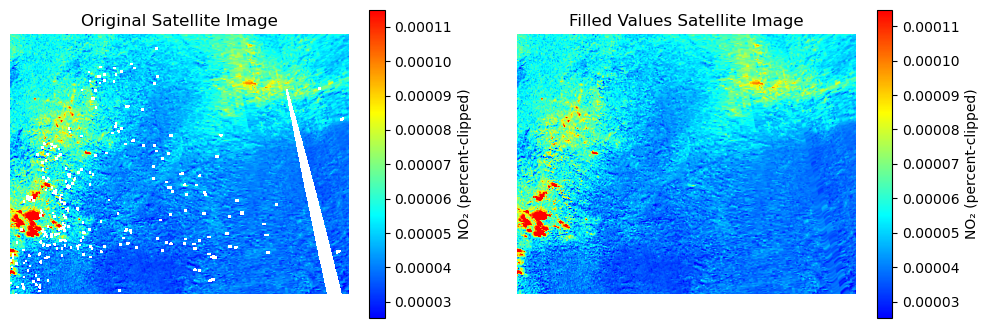

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# plot original image
src, band, profile, nodata_value = read_tiff(DEMO_PATH / 'Ethiopia_NO2_2023-01-01.tif')
plot_raster(band, percent_clip=0.5, ax=axes[0], title="Original Satellite Image")

# filled image
src, band_filled, profile, nodata_value = read_tiff(DEMO_PATH / 'Ethiopia_NO2_2023-01-01_filled.tif')
plot_raster(band_filled, percent_clip=0.5, ax=axes[1], title="Filled Values Satellite Image")

plt.show()

From the figure on the left, there are missing values in the plot, represented by the small white regions.  It is clear that the small missing parts in the original figure are filled perfectly.

#### Iraq - Baghdad

After processed the following cell, comment it.

In [ ]:
from missingvalue import fill_missing_data

iraq_tiff_path = DATA_PATH / 'Iraq-no2'
fill_missing_data('Iraq', data_tiff_path=iraq_tiff_path, output_path=DATA_PATH)

**Visualisation**

Use *Iraq_NO2_2023-01-01.tif* file as an example to show the results of filling missing value.

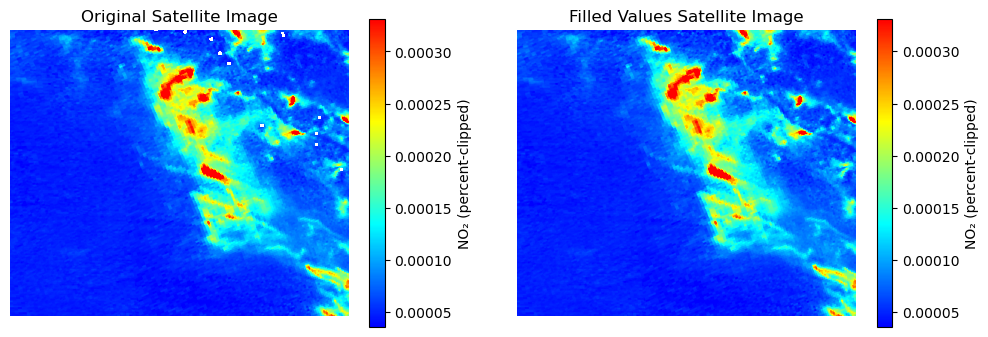

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# plot original image
src, band, profile, nodata_value = read_tiff(DEMO_PATH / 'Iraq_NO2_2023-01-01.tif')
plot_raster(band, percent_clip=0.5, ax=axes[0], title="Original Satellite Image")

# filled image
src, band_filled, profile, nodata_value = read_tiff(DEMO_PATH / 'Iraq_NO2_2023-01-01_filled.tif')
plot_raster(band_filled, percent_clip=0.5, ax=axes[1], title="Filled Values Satellite Image")

plt.show()

Similarly, the small missing value areas on the upper right are filled perfectly. Thus, the iterative filling method can significantly enhance the data quality.

### 1.2 Aggregate Based on Mesh Grid

In [ ]:
from aggregation import*

addis_meshes_path = DATA_PATH / 'addis-mesh-data'
baghdad_meshes_path = DATA_PATH / 'baghdad-mesh-data'

mesh_addis = DATA_PATH / "mesh-grid" / "grid_addis_ababa.gpkg"
mesh_baghdad = DATA_PATH / "mesh-grid" / "grid_baghdad.gpkg"

lyr_addis_name = fiona.listlayers(mesh_addis)[0]         # control layer number = 1 
lyr_baghdad_name = fiona.listlayers(mesh_baghdad)[0]

#### Ethiopia - Addis Ababa

In [ ]:
# Aggregate Ethiopia - Addis Ababa
eth_no2_filled_path = DATA_PATH / 'Ethiopia-no2-filled'
aggregate_data(
    data_tiff_path=eth_no2_filled_path, 
    mesh_path=addis_meshes_path, 
    layer_name=lyr_addis_name,
    feature_name="no2_mean"
    )

**Visualisation**

Show aggregated result in 2023-01-01 in Addis Ababa.

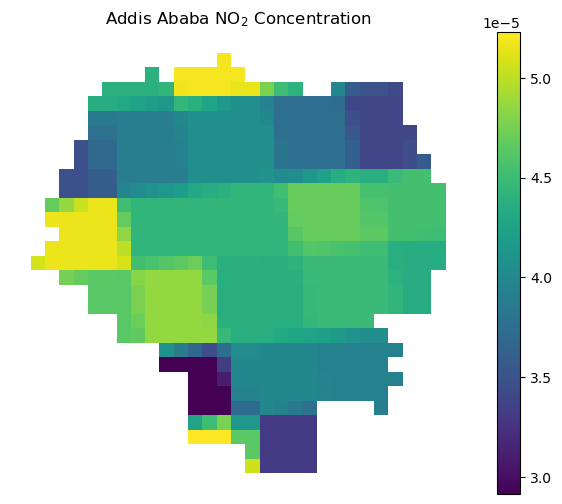

In [23]:
demo_mesh = gpd.read_file(DEMO_PATH / 'addis-ababa-2023-01-01.gpkg')
plot_mesh(mesh=demo_mesh, feature='no2_mean', title="Addis Ababa NO$_2$ Concentration", show_edges=False)
plt.show()

#### Iraq - Baghdad

In [ ]:
# Aggregate Iraq - Baghdad
iraq_no2_filled_path = DATA_PATH / 'Iraq-no2-filled'
aggregate_data(
    data_tiff_path=iraq_no2_filled_path, 
    mesh_path=baghdad_meshes_path, 
    layer_name=lyr_baghdad_name,
    feature_name="no2_mean"
    )

**Visualisation**

Show aggregated result in 2023-01-01 in Baghdad.

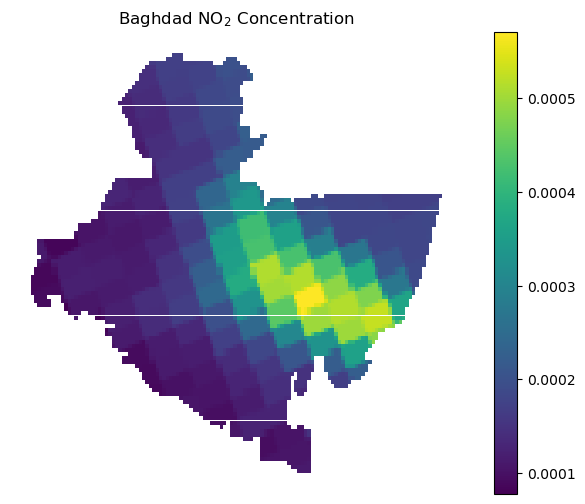

In [22]:
demo_mesh = gpd.read_file(DEMO_PATH / 'baghdad-2023-01-01.gpkg')
plot_mesh(mesh=demo_mesh, feature='no2_mean', title="Baghdad NO$_2$ Concentration", show_edges=False)
plt.show()

## 2 Data Visualisation

This chapter is used to generate a dynamic figure, to show how the NO2 distribution changes over time.

Note:

- In the coloration system, percentile clipping and contrast stretching method is used to improve the visual effects of the image.

- In this chapter, the dynamic distribution of NO2 is generated, in format of GIF. 

### 2.1 Dynamic NO2 Distribution - Country Level

#### Ethiopia - Addis Ababa

Scanning percentiles: 100%|██████████| 131/131 [00:13<00:00,  9.96it/s]


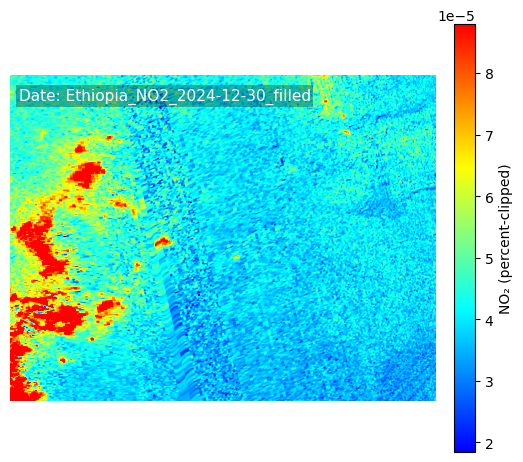

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\ethiopia-no2-animation.gif


In [ ]:
no2_eth_tif_dir = DATA_PATH / 'Ethiopia-no2-filled'  
tiff_2_gif(no2_eth_tif_dir, output_path=DATA_PATH, output_name="ethiopia-no2-animation", fps = 8)

#### Iraq - Baghdad

Scanning percentiles: 100%|██████████| 720/720 [00:38<00:00, 18.75it/s]


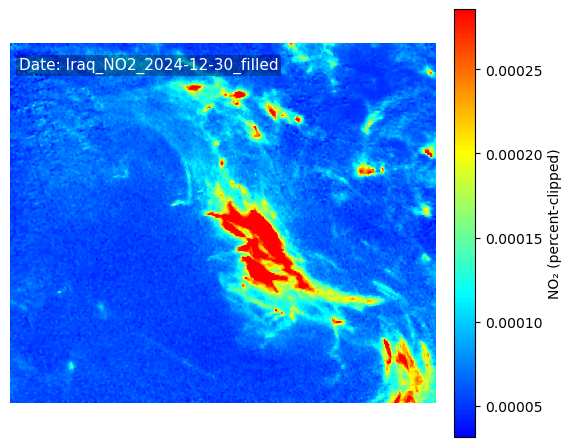

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\iraq-no2-animation.gif


In [8]:
no2_iraq_tif_dir= DATA_PATH / 'Iraq-no2-filled'  
tiff_2_gif(no2_iraq_tif_dir, output_path=DATA_PATH, output_name="iraq-no2-animation", fps = 8)

### 2.2 Dynamic NO2 Mesh - City Level

#### Ethiopia - Addis Ababa

Scanning percentiles: 100%|██████████| 731/731 [00:07<00:00, 93.50it/s] 


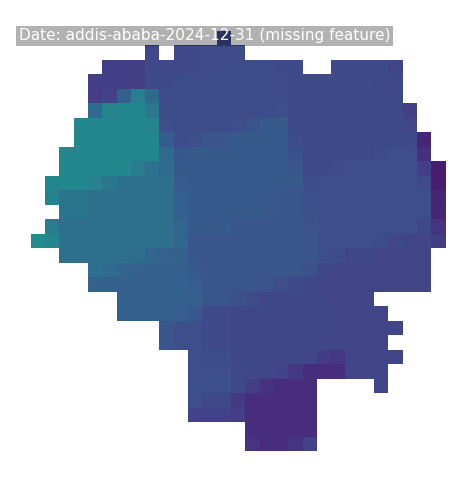

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\addis-ababa-no2-animation.gif


In [ ]:
addis_gpkg_path = DATA_PATH / 'addis-no2-mesh-data'

mesh_2_gif(
    gpkg_path=addis_gpkg_path, 
    output_path=DATA_PATH,
    output_name= "addis-ababa-no2-animation", 
    feature='no2_mean',
   )
plt.show()

#### Iraq - Baghdad

Scanning percentiles: 100%|██████████| 731/731 [00:24<00:00, 30.02it/s]


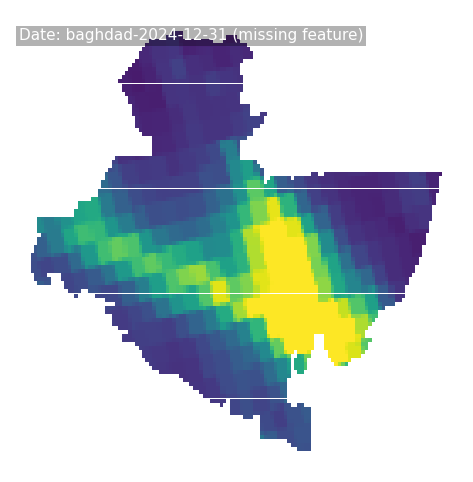

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\baghdad-no2-animation.gif


In [ ]:
baghdad_gpkg_path = DATA_PATH / 'baghdad-no2-mesh-data'

mesh_2_gif(
    gpkg_path=baghdad_gpkg_path, 
    output_path=DATA_PATH,
    output_name= "baghdad-no2-animation", 
    feature='no2_mean',
   )
plt.show()

### 2.3 NO₂ Daily Time Series Visualization by administrative Zones

#### Ethiopia - Addis Ababa

In [3]:
# Data paths and settings (relative paths)
data_folder = DATA_PATH / "addis-ababa-no2-mesh"
shapefile_path = DEMO_PATH / "addis-ababa-adm3.shp"
output_folder_2023 = DATA_PATH / "addis-ababa-zonal-time-series-plots/2023"
output_folder_2024 = DATA_PATH / "addis-ababa-zonal-time-series-plots/2024"
output_folder_2023.mkdir(exist_ok=True)
output_folder_2024.mkdir(exist_ok=True)


**2023**

/var/folders/5f/4xtp460569d8xfc5ygcs9w500000gp/T/ipykernel_7256/2465498058.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(time_series_data)


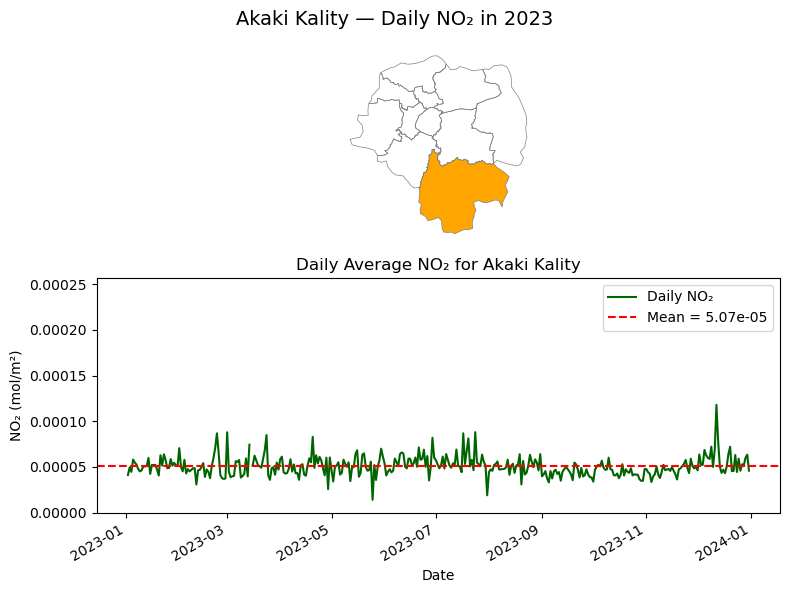

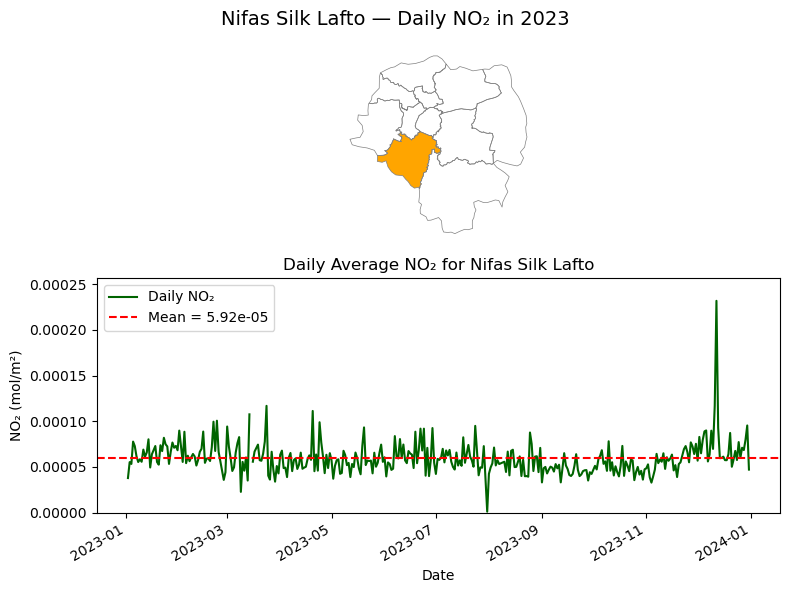

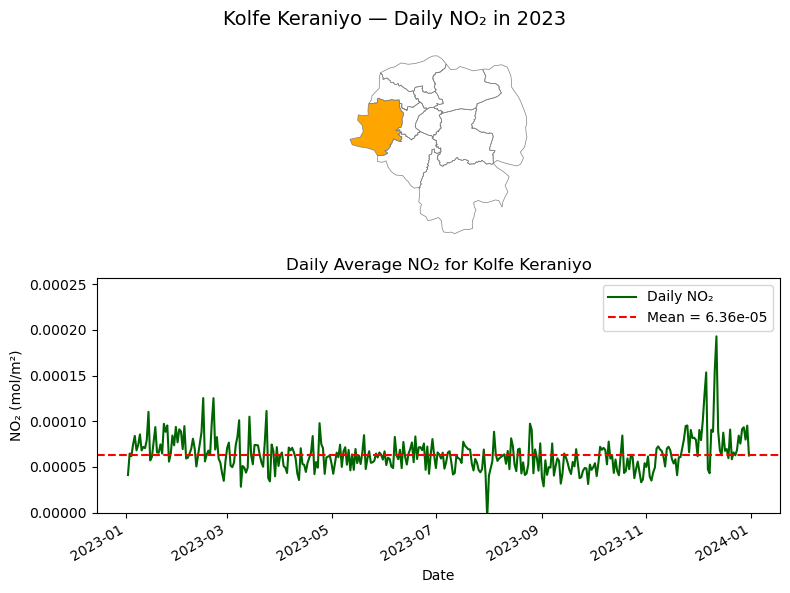

In [4]:
# Load administrative boundary
adm3 = gpd.read_file(shapefile_path).to_crs(epsg=4326)
adm3 = adm3.reset_index(drop=True).reset_index().rename(columns={"index": "adm_id"})

# Initialize an empty list to collect daily NO2 averages
time_series_data = []

# Loop through daily GPKG files and calculate mean NO2 for each ADM3 zone
for f in sorted(os.listdir(data_folder)):
    if not f.endswith(".gpkg") or not f.startswith("addis-ababa-2023"):
        continue

    date_str = f.split("addis-ababa-")[1].replace(".gpkg", "")
    try:
        date = datetime.strptime(date_str, "%Y-%m-%d")
    except:
        continue

    gdf = gpd.read_file(data_folder / f)
    if gdf.empty or "no2_mean" not in gdf.columns:
        continue

    gdf = gdf[gdf.geometry.notnull() & gdf.is_valid]
    gdf = gdf.dropna(subset=["no2_mean"])
    gdf = gdf.to_crs(adm3.crs)

    joined = gpd.sjoin(gdf, adm3, how="inner", predicate="intersects")
    daily_avg = joined.groupby("adm_id")["no2_mean"].mean().reset_index()
    daily_avg["date"] = date
    time_series_data.append(daily_avg)

# panel-format dataframe
df_all = pd.concat(time_series_data)
pivot_df = df_all.pivot(index="date", columns="adm_id", values="no2_mean")

# Calculate overall max NO₂ value across all zones to standardize y-axis
ymax = pivot_df.max().max()

# Plot and save figures
for i, adm_id in enumerate(pivot_df.columns):
    adm_name = adm3.loc[adm3.adm_id == adm_id, "ADM3_EN"].values[0]
    series = pivot_df[adm_id]

    fig, (ax_map, ax_line) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [1, 1.2]})
    fig.suptitle(f"{adm_name} — Daily NO₂ in 2023", fontsize=14)

    # Top subplot: map with the selected ADM3 zone highlighted
    adm3.boundary.plot(ax=ax_map, linewidth=0.5, edgecolor="gray")
    adm3.loc[adm3.adm_id == adm_id].plot(ax=ax_map, color="orange")
    ax_map.axis("off")

    # Bottom subplot: time series with mean line
    series.plot(ax=ax_line, color="darkgreen", label="Daily NO₂")
    mean_val = series.mean()
    ax_line.axhline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_val:.2e}")

    ax_line.set_ylabel("NO₂ (mol/m²)")
    ax_line.set_xlabel("Date")
    ax_line.set_ylim(0, ymax * 1.1)
    ax_line.set_title(f"Daily Average NO₂ for {adm_name}")
    ax_line.legend()

    plt.tight_layout()

    # Show only the first 3 plots
    if i < 3:
        plt.show()

    # Save all plots
    out_path = output_folder_2023 / f"{adm_name.replace(' ', '_')}.png"
    fig.savefig(out_path, dpi=100)
    plt.close()


**2024**

/var/folders/5f/4xtp460569d8xfc5ygcs9w500000gp/T/ipykernel_7256/364043073.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(time_series_data)


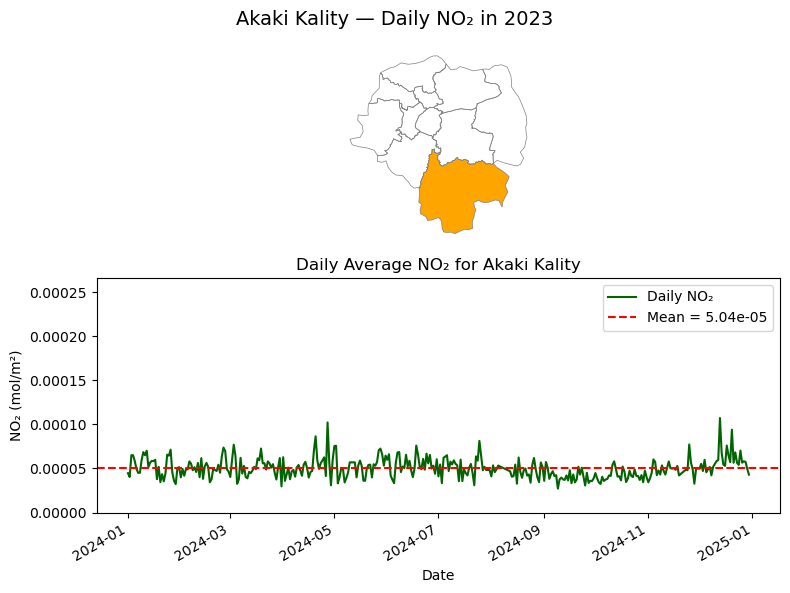

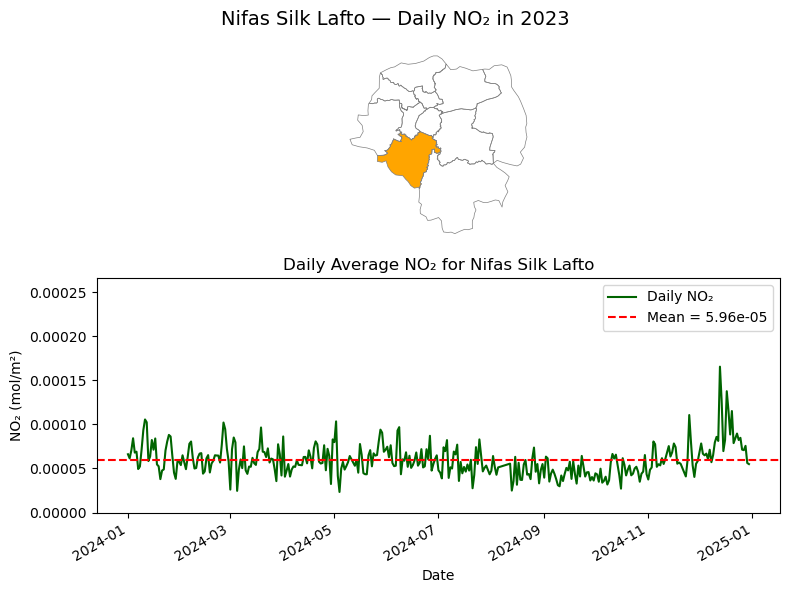

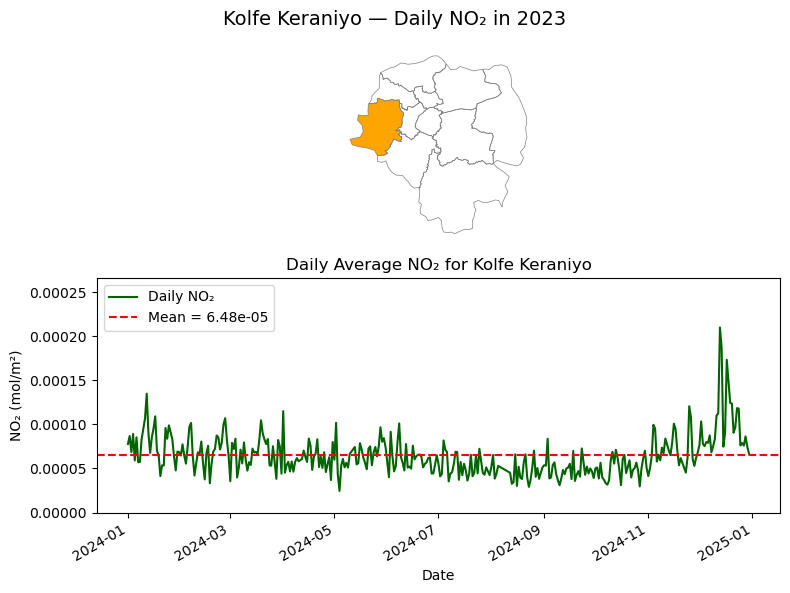

In [5]:
# Initialize an empty list to collect daily NO2 averages
time_series_data = []

# Loop through daily GPKG files and calculate mean NO2 for each ADM3 zone
for f in sorted(os.listdir(data_folder)):
    if not f.endswith(".gpkg") or not f.startswith("addis-ababa-2024"):
        continue

    date_str = f.split("addis-ababa-")[1].replace(".gpkg", "")
    try:
        date = datetime.strptime(date_str, "%Y-%m-%d")
    except:
        continue

    gdf = gpd.read_file(data_folder / f)
    if gdf.empty or "no2_mean" not in gdf.columns:
        continue

    gdf = gdf[gdf.geometry.notnull() & gdf.is_valid]
    gdf = gdf.dropna(subset=["no2_mean"])
    gdf = gdf.to_crs(adm3.crs)

    joined = gpd.sjoin(gdf, adm3, how="inner", predicate="intersects")
    daily_avg = joined.groupby("adm_id")["no2_mean"].mean().reset_index()
    daily_avg["date"] = date
    time_series_data.append(daily_avg)

# panel-format dataframe
df_all = pd.concat(time_series_data)
pivot_df = df_all.pivot(index="date", columns="adm_id", values="no2_mean")

# Calculate overall max NO₂ value across all zones to standardize y-axis
ymax = pivot_df.max().max()

# Plot and save figures
for i, adm_id in enumerate(pivot_df.columns):
    adm_name = adm3.loc[adm3.adm_id == adm_id, "ADM3_EN"].values[0]
    series = pivot_df[adm_id]

    fig, (ax_map, ax_line) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [1, 1.2]})
    fig.suptitle(f"{adm_name} — Daily NO₂ in 2023", fontsize=14)

    # Top subplot: map with the selected ADM3 zone highlighted
    adm3.boundary.plot(ax=ax_map, linewidth=0.5, edgecolor="gray")
    adm3.loc[adm3.adm_id == adm_id].plot(ax=ax_map, color="orange")
    ax_map.axis("off")

    # Bottom subplot: time series with mean line
    series.plot(ax=ax_line, color="darkgreen", label="Daily NO₂")
    mean_val = series.mean()
    ax_line.axhline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_val:.2e}")

    ax_line.set_ylabel("NO₂ (mol/m²)")
    ax_line.set_xlabel("Date")
    ax_line.set_ylim(0, ymax * 1.1)
    ax_line.set_title(f"Daily Average NO₂ for {adm_name}")
    ax_line.legend()

    plt.tight_layout()

    # Show only the first 3 plots
    if i < 3:
        plt.show()

    # Save all plots
    out_path = output_folder_2024 / f"{adm_name.replace(' ', '_')}.png"
    fig.savefig(out_path, dpi=100)
    plt.close()


#### Iraq - Baghdad

In [6]:
# Data paths and settings (relative paths)
data_folder = DATA_PATH / "baghdad-no2-mesh"
shapefile_path = DEMO_PATH / "baghdad-adm3.shp"
output_folder_2023 = DATA_PATH / "baghdad-zonal-time-series-plots/2023"
output_folder_2024 = DATA_PATH / "baghdad-zonal-time-series-plots/2024"
output_folder_2023.mkdir(exist_ok=True)
output_folder_2024.mkdir(exist_ok=True)


**2023**

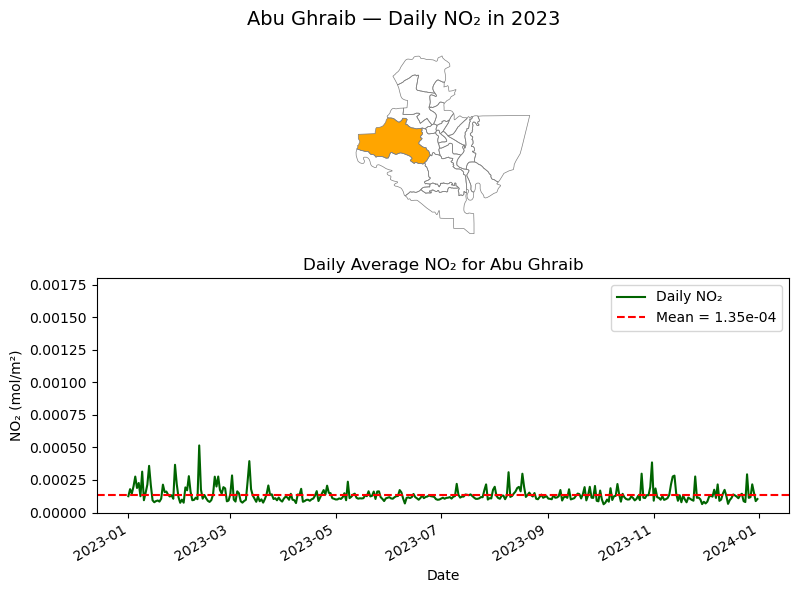

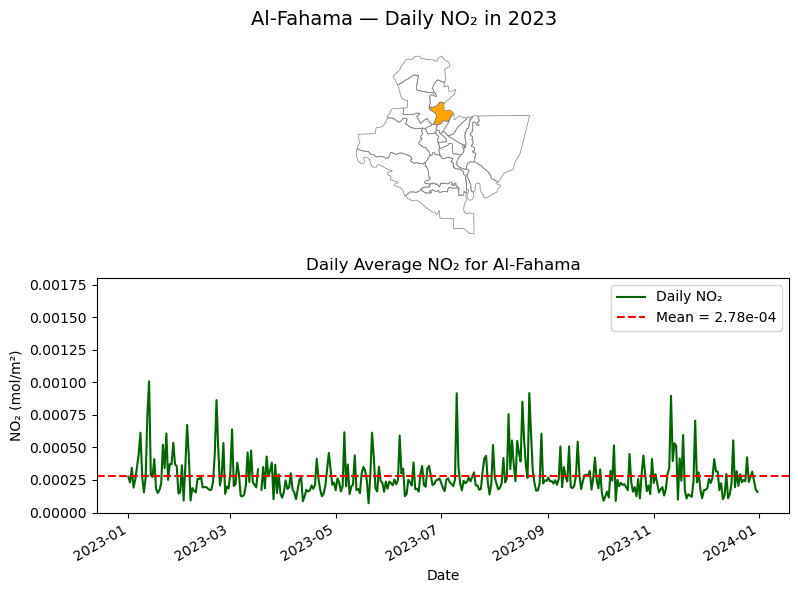

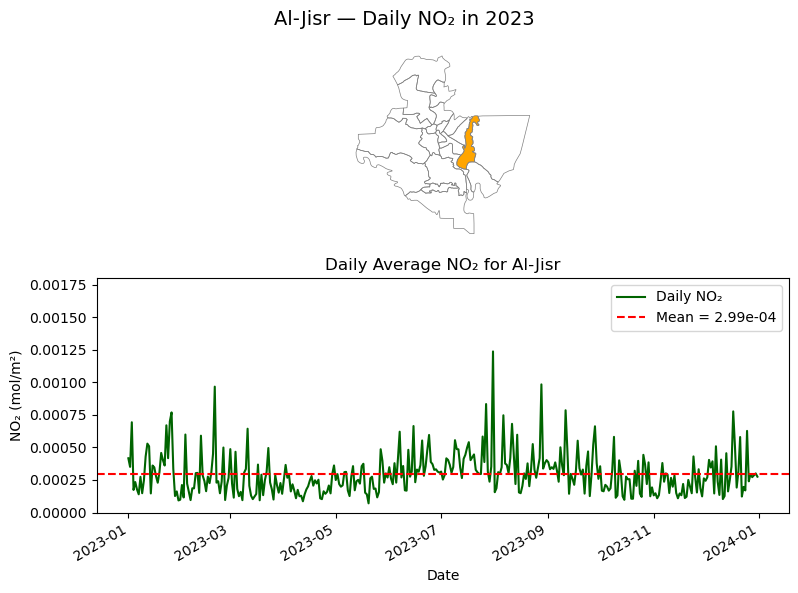

In [7]:
# Load administrative boundary
adm3 = gpd.read_file(shapefile_path).to_crs(epsg=4326)
adm3 = adm3.reset_index(drop=True).reset_index().rename(columns={"index": "adm_id"})

# Initialize an empty list to collect daily NO2 averages
time_series_data = []

# Loop through daily GPKG files and calculate mean NO2 for each ADM3 zone
for f in sorted(os.listdir(data_folder)):
    if not f.endswith(".gpkg") or not f.startswith("baghdad-2023"):
        continue

    date_str = f.split("baghdad-")[1].replace(".gpkg", "")
    try:
        date = datetime.strptime(date_str, "%Y-%m-%d")
    except:
        continue

    gdf = gpd.read_file(data_folder / f)
    if gdf.empty or "no2_mean" not in gdf.columns:
        continue

    gdf = gdf[gdf.geometry.notnull() & gdf.is_valid]
    gdf = gdf.dropna(subset=["no2_mean"])
    gdf = gdf.to_crs(adm3.crs)

    joined = gpd.sjoin(gdf, adm3, how="inner", predicate="intersects")
    daily_avg = joined.groupby("adm_id")["no2_mean"].mean().reset_index()
    daily_avg["date"] = date
    time_series_data.append(daily_avg)

# panel-format dataframe
df_all = pd.concat(time_series_data)
pivot_df = df_all.pivot(index="date", columns="adm_id", values="no2_mean")

# Calculate overall max NO₂ value across all zones to standardize y-axis
ymax = pivot_df.max().max()

# Plot and save figures
for i, adm_id in enumerate(pivot_df.columns):
    adm_name = adm3.loc[adm3.adm_id == adm_id, "ADM3_EN"].values[0]
    series = pivot_df[adm_id]

    fig, (ax_map, ax_line) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [1, 1.2]})
    fig.suptitle(f"{adm_name} — Daily NO₂ in 2023", fontsize=14)

    # Top subplot: map with the selected ADM3 zone highlighted
    adm3.boundary.plot(ax=ax_map, linewidth=0.5, edgecolor="gray")
    adm3.loc[adm3.adm_id == adm_id].plot(ax=ax_map, color="orange")
    ax_map.axis("off")

    # Bottom subplot: time series with mean line
    series.plot(ax=ax_line, color="darkgreen", label="Daily NO₂")
    mean_val = series.mean()
    ax_line.axhline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_val:.2e}")

    ax_line.set_ylabel("NO₂ (mol/m²)")
    ax_line.set_xlabel("Date")
    ax_line.set_ylim(0, ymax * 1.1)
    ax_line.set_title(f"Daily Average NO₂ for {adm_name}")
    ax_line.legend()

    plt.tight_layout()

    # Show only the first 3 plots
    if i < 3:
        plt.show()

    # Save all plots
    out_path = output_folder_2023 / f"{adm_name.replace(' ', '_')}.png"
    fig.savefig(out_path, dpi=100)
    plt.close()


**2024**

/var/folders/5f/4xtp460569d8xfc5ygcs9w500000gp/T/ipykernel_7256/2384218097.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(time_series_data)


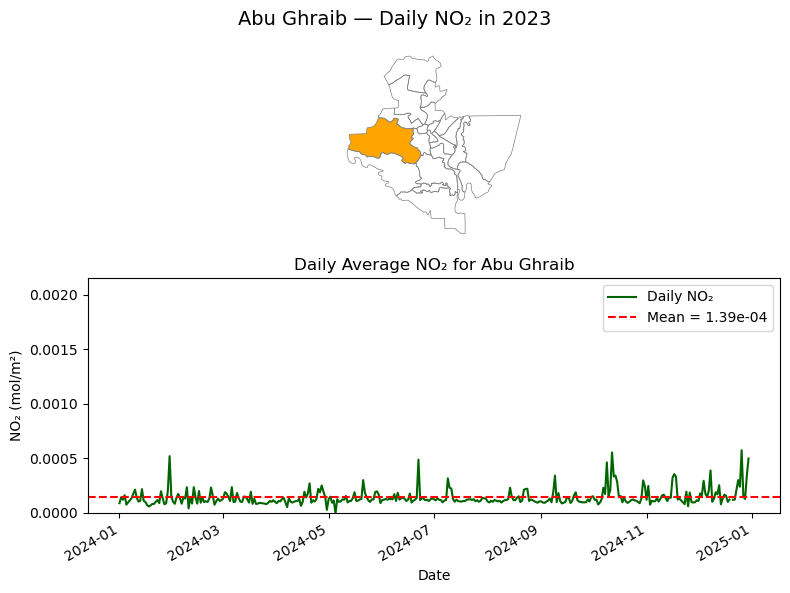

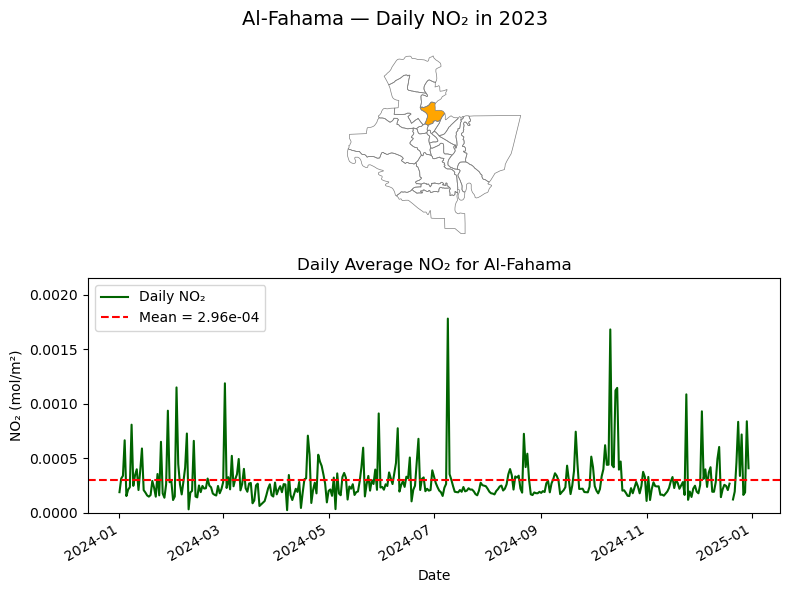

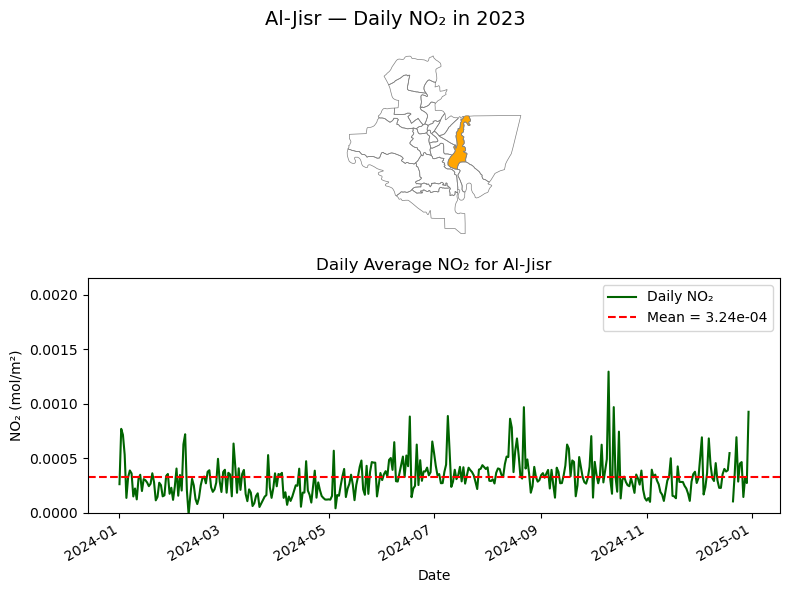

In [8]:
# Initialize an empty list to collect daily NO2 averages
time_series_data = []

# Loop through daily GPKG files and calculate mean NO2 for each ADM3 zone
for f in sorted(os.listdir(data_folder)):
    if not f.endswith(".gpkg") or not f.startswith("baghdad-2024"):
        continue

    date_str = f.split("baghdad-")[1].replace(".gpkg", "")
    try:
        date = datetime.strptime(date_str, "%Y-%m-%d")
    except:
        continue

    gdf = gpd.read_file(data_folder / f)
    if gdf.empty or "no2_mean" not in gdf.columns:
        continue

    gdf = gdf[gdf.geometry.notnull() & gdf.is_valid]
    gdf = gdf.dropna(subset=["no2_mean"])
    gdf = gdf.to_crs(adm3.crs)

    joined = gpd.sjoin(gdf, adm3, how="inner", predicate="intersects")
    daily_avg = joined.groupby("adm_id")["no2_mean"].mean().reset_index()
    daily_avg["date"] = date
    time_series_data.append(daily_avg)

# panel-format dataframe
df_all = pd.concat(time_series_data)
pivot_df = df_all.pivot(index="date", columns="adm_id", values="no2_mean")

# Calculate overall max NO₂ value across all zones to standardize y-axis
ymax = pivot_df.max().max()

# Plot and save figures
for i, adm_id in enumerate(pivot_df.columns):
    adm_name = adm3.loc[adm3.adm_id == adm_id, "ADM3_EN"].values[0]
    series = pivot_df[adm_id]

    fig, (ax_map, ax_line) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [1, 1.2]})
    fig.suptitle(f"{adm_name} — Daily NO₂ in 2023", fontsize=14)

    # Top subplot: map with the selected ADM3 zone highlighted
    adm3.boundary.plot(ax=ax_map, linewidth=0.5, edgecolor="gray")
    adm3.loc[adm3.adm_id == adm_id].plot(ax=ax_map, color="orange")
    ax_map.axis("off")

    # Bottom subplot: time series with mean line
    series.plot(ax=ax_line, color="darkgreen", label="Daily NO₂")
    mean_val = series.mean()
    ax_line.axhline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_val:.2e}")

    ax_line.set_ylabel("NO₂ (mol/m²)")
    ax_line.set_xlabel("Date")
    ax_line.set_ylim(0, ymax * 1.1)
    ax_line.set_title(f"Daily Average NO₂ for {adm_name}")
    ax_line.legend()

    plt.tight_layout()

    # Show only the first 3 plots
    if i < 3:
        plt.show()

    # Save all plots
    out_path = output_folder_2024 / f"{adm_name.replace(' ', '_')}.png"
    fig.savefig(out_path, dpi=100)
    plt.close()
